In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt 
import LucaM185

# Tiny-shakespeare dataset
Now we will move to a real world task, next-character prediction with the tiny-shakespeare dataset

In [14]:
with open("datasets/tinyShakespeare.txt", "r") as f:
    load = f.read()
print(load[:200])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you


In [15]:
texttoint = {elm: n for n, elm in enumerate(set(load))}
inttotext = {n: elm for n, elm in enumerate(set(load))}
dataset = [texttoint[c] for c in load] # list of ints

sequence_length = 1
vocab_size = len(texttoint)
inputs = torch.tensor(dataset[:-1])
labels = torch.tensor(dataset[1:])
print(vocab_size)

65


**One-hot encoding** converts class labels into binary vectors, making them orthogonal. Neural networks excel at recognizing vector orthogonality, unlike differences in raw integer values. 

For 4 classes (0–3):  
- Class 0 → `[1, 0, 0, 0]`  
- Class 1 → `[0, 1, 0, 0]`  
- Class 2 → `[0, 0, 1, 0]`  
- Class 3 → `[0, 0, 0, 1]`  


In [16]:
onehot = F.one_hot(inputs[:4].long(), vocab_size).float()
print(inputs[:4])
print(onehot)

tensor([59, 30, 64, 13])
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
   

# Perceptron
This complex dataset requires us to build on logistic regression and scale it a lot to make an architecture that can deal with this kind of data  <br>
We are starting with the Perceptron and we are training in batches, the number of features is called vocab_size (65)

In [18]:
m = torch.randn(vocab_size, vocab_size) * (6**0.5 / (vocab_size + vocab_size)**0.5)  
q = torch.zeros(vocab_size) 

m.requires_grad_()
q.requires_grad_()

epochs = 10000  # high number of epochs
lr = 1e-2  # high learning rate
batch_size = 1024  # taking a batch of 1024 samples at a time

for epoch in range(epochs):
    indexes = torch.randint(0, len(inputs), (batch_size,))  # generating random indexes

    pred = F.one_hot(inputs[indexes].long(), vocab_size).float() @ m + q
    loss = F.cross_entropy(pred, labels[indexes])
    loss.backward()

    with torch.no_grad():
        m -= lr * m.grad
        q -= lr * q.grad
        m.grad = None
        q.grad = None
    
    if epoch % (epochs//10) == 0:
        print(loss.item())

4.189844608306885
3.792034149169922
3.5766987800598145
3.4952504634857178
3.37138295173645
3.363522529602051
3.2526495456695557
3.234034299850464
3.19571590423584
3.127828359603882


This is cool, we can achieve a pretty decent loss, but some problems are way harder and can't be tackled with a solution this simple... <br>
Remember what we did earlier? We expanded our logistic regressor to make a Perceptron, now we can try expanding the perceptron in the forward direction <br>
This architecture should resemble a network of biological neurons, this is called Multi Layer Perceptron

# MLP



In [19]:
hidden_size = 128

w1 = torch.randn(vocab_size, hidden_size) * (6**0.5 / (vocab_size + hidden_size)**0.5)  
b1 = torch.zeros(hidden_size) 
w2 = torch.randn(hidden_size, vocab_size) * (6**0.5 / (vocab_size + hidden_size)**0.5)
b2 = torch.zeros(vocab_size)

for p in [w1, b1, w2, b2]:
    p.requires_grad_()

epochs = 10000
lr = 1e-2
batch_size = 1024
lossi = []

for epoch in range(epochs):
    indexes = torch.randint(0, len(inputs), (batch_size,))
    
    X = F.one_hot(inputs[indexes].long(), vocab_size).float()
    h1 = F.gelu(X @ w1 + b1)
    pred = h1 @ w2 + b2
    loss = F.cross_entropy(pred, labels[indexes])
    lossi.append(loss.item())
    loss.backward()

    with torch.no_grad():
        for p in [w1, b1, w2, b2]:
            p -= lr * p.grad  # step
            p.grad = None  # zero grad

    if epoch % (epochs//10) == 0:
        print(loss.item())

4.209502220153809
3.500349760055542
3.315089464187622
3.2076051235198975
3.089519739151001
3.062234878540039
3.0395185947418213
2.864009141921997
3.008418083190918
2.800873041152954


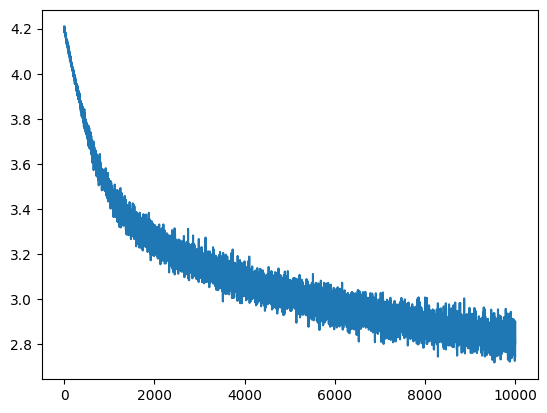

In [20]:
plt.plot(lossi)

# Optimizer

The architecture looks right but the loss is not going down as well as expected, let's try changing simple gradient descent to a more elaborate optimizer <br>
We won't bother coding this up by ourselves because it's already implemented in pytorch and really easy to use from there <br>
If you want, you can change from torch.optim.Adam to torch.optim.SGD and look how fast Adam really is

In [21]:
hidden_size = 128

w1 = torch.randn(vocab_size, hidden_size) * (6**0.5 / (vocab_size + hidden_size)**0.5)  
b1 = torch.zeros(hidden_size) 
w2 = torch.randn(hidden_size, vocab_size) * (6**0.5 / (vocab_size + hidden_size)**0.5)
b2 = torch.zeros(vocab_size)

for p in [w1, b1, w2, b2]:
    p.requires_grad_()

epochs = 10000
lr = 1e-2
batch_size = 1024
optimizer = torch.optim.Adam([w1, b1, w2, b2], lr=1e-2)
lossi = []

for epoch in range(epochs):
    indexes = torch.randint(0, len(inputs), (batch_size,))

    X = F.one_hot(inputs[indexes].long(), vocab_size).float()
    h1 = F.gelu(X @ w1 + b1)
    pred = h1 @ w2 + b2
    loss = F.cross_entropy(pred, labels[indexes])
    lossi.append(loss.item())
    loss.backward()

    optimizer.step()
    optimizer.zero_grad()

    if epoch % (epochs//10) == 0:
        print(loss.item())

4.173213481903076
2.5270583629608154
2.459476947784424
2.4948556423187256
2.5167341232299805
2.466869592666626
2.396477699279785
2.416057586669922
2.4634406566619873
2.4424939155578613


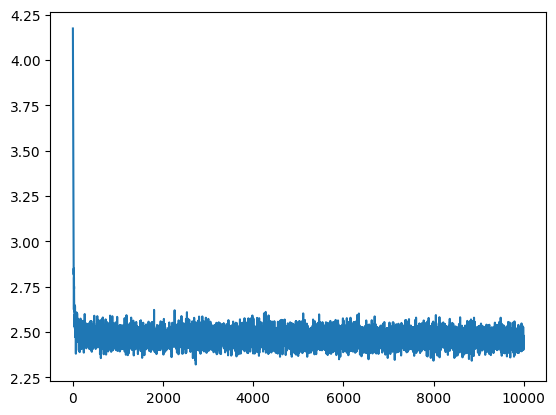

In [22]:
plt.plot(lossi)

# Example output

In [28]:
string = "The meaning of life is: \n"

with torch.no_grad():
    for _ in range(100):
        X = F.one_hot(torch.tensor(texttoint[string[-1]]), vocab_size).float()
        h1 = F.gelu(X @ w1 + b1)
        pred = h1 @ w2 + b2
        string += inttotext[torch.multinomial(F.softmax(pred, dim=0), 1).item()]
        print(string[-1], end="")


YOHese
Lak totoushougny gend?
LEVO:
AYBe, garener weshelaichind t her we's ais test authathistar t t